In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Lade die numpy-Datei
z_data = np.load(r"C:\Users\lspillec\Nextcloud\Geotechnik-Freigaben\Dienstleistung\Versuche_FuE\F_05_Schüttkegel_Anton\z_20250825_103855.npy")
lumi_data = np.load(r"C:\Users\lspillec\Nextcloud\Geotechnik-Freigaben\Dienstleistung\Versuche_FuE\F_05_Schüttkegel_Anton\lumi_20250825_103855.npy")  

In [ ]:
def interpolate_outliers_linear_radial(
    z_data: np.ndarray,
    peak_index: int = 300,
    switch_index: int | None = None,
    threshold: float | None = None,     # z.B. 20000  → Werte darunter gelten als Ausreißer
    max_gap: int = 8,                   # nur NaN-Intervalle mit Länge ≤ max_gap werden gefüllt
    fill_edge: str = "nearest",         # "nearest" oder "const"
    fill_edge_value: float = 0.0,       # nur relevant wenn fill_edge="const"
    inplace: bool = False,
) -> np.ndarray:
    """
    Markiert Werte < threshold als Ausreißer (NaN) und interpoliert sie
    je Spalte (Winkel) radial linear, aber nur für Lücken ≤ max_gap.
    Bereich: [peak_index : switch_index)  (switch_index=None -> bis Ende).
    """
    if z_data.ndim != 2:
        raise ValueError("z_data muss 2D sein: (punkte_pro_scan, anzahl_scans)")

    n_points, n_scans = z_data.shape
    if not (0 <= peak_index < n_points):
        raise ValueError("peak_index außerhalb des gültigen Bereichs.")

    r0 = peak_index
    r1 = n_points if switch_index is None else max(min(switch_index, n_points), r0 + 1)

    out = z_data if inplace else z_data.copy()
    Z = out[r0:r1, :]           # Arbeitsfenster (Nr, M)
    Nr, M = Z.shape

    # 1) Optional: „zu niedrige“ Ausreißer zu NaN machen
    if threshold is not None:
        low_mask = Z < threshold
        Z = Z.astype(float)
        Z[low_mask] = np.nan

    # 2) Spaltenweise radial interpolieren (nur Lücken ≤ max_gap)
    idx_all = np.arange(Nr)

    for j in range(M):
        col = Z[:, j]

        # a) Randbehandlung
        if np.all(np.isnan(col)):
            continue  # nichts möglich
        if fill_edge == "nearest":
            # vorne
            first_valid = np.argmax(~np.isnan(col))
            if np.isnan(col[0]) and not np.isnan(col[first_valid]):
                col[:first_valid] = col[first_valid]
            # hinten
            last_valid = Nr - 1 - np.argmax(~np.isnan(col[::-1]))
            if np.isnan(col[-1]) and not np.isnan(col[last_valid]):
                col[last_valid+1:] = col[last_valid]
        elif fill_edge == "const":
            # konstante Füllung an den Rändern
            # vorne
            k = 0
            while k < Nr and np.isnan(col[k]):
                col[k] = fill_edge_value
                k += 1
            # hinten
            k = Nr - 1
            while k >= 0 and np.isnan(col[k]):
                col[k] = fill_edge_value
                k -= 1

        # b) nur kurze NaN-Intervalle füllen
        # finde NaN-Run-Längen
        isn = np.isnan(col)
        if not np.any(isn):
            Z[:, j] = col
            continue

        # Läufe der Form [s:e) mit NaN
        k = 0
        while k < Nr:
            if not isn[k]:
                k += 1
                continue
            s = k
            while k < Nr and isn[k]:
                k += 1
            e = k  # NaN-Block = [s, e-1]
            gap_len = e - s

            if gap_len <= max_gap:
                # Interpolation zwischen col[s-1] und col[e] (sofern vorhanden)
                left_idx  = s - 1 if s - 1 >= 0 and not np.isnan(col[s - 1]) else None
                right_idx = e     if e < Nr and not np.isnan(col[e])       else None

                if left_idx is not None and right_idx is not None:
                    x = np.array([left_idx, right_idx], dtype=float)
                    y = np.array([col[left_idx], col[right_idx]], dtype=float)
                    xi = np.arange(s, e, dtype=float)
                    col[s:e] = np.interp(xi, x, y)
                # Falls ein Rand ungültig ist, bleibt die Lücke (durch a) i.d.R. schon gefüllt)
                # Andernfalls lassen wir die NaNs bestehen.
        Z[:, j] = col

    # 3) Ergebnis zurückschreiben und liefern
    out[r0:r1, :] = Z
    return out

def plot_heightmap_from_scans_dualscale(
    z_data: np.ndarray,
    lumi_data: np.ndarray,
    peak_index: int = 300,
    scans_per_rev: int = 13_000,
    step: int = 100,
    rotation_idx: int = 0,
    switch_index: int = 2400,
    y_window_out: tuple[int, int] | None = None,  # (r_min, r_max) ab peak (in Pixeln)
    show_colorbars: bool = True,
    # getrennte Skalen:
    z_vmin: float = 20_000, z_vmax: float = 35_000,
    lumi_vmin: float = 0.0, lumi_vmax: float = 1024.0,
    # neue Skalierungen & Einheiten
    scale_height: float = 1.0,      # z-Einheit -> mm (z.B. 0.001)
    scale_length: float = 1.0,      # Pixel -> mm (z.B. 0.05)
    height_unit: str = "mm",
    length_unit: str = "mm",
    label_z: str = "Laserhöhe (z_data)",
    label_lumi: str = "Luminanz (lumi_data)",
    cmap="hsv"
):
    """Kartesische Heightmap, nur ab peak_index; z hat eigene Skala, lumi eigene."""
    if z_data.ndim != 2 or lumi_data.ndim != 2:
        raise ValueError("z_data und lumi_data müssen 2D sein")
    if z_data.shape != lumi_data.shape:
        raise ValueError(f"Shapes unterschiedlich: {z_data.shape} vs {lumi_data.shape}")

    n_points, n_scans = z_data.shape
    if not (0 <= peak_index < n_points):   raise ValueError("peak_index out of range")
    if not (0 <= switch_index < n_points): raise ValueError("switch_index out of range")

    start = rotation_idx * scans_per_rev
    end   = min(start + scans_per_rev, n_scans)
    if start >= n_scans: raise ValueError("rotation_idx außerhalb")

    Zz = z_data[:,   start:end:step]
    Zl = lumi_data[:, start:end:step]
    n_used_scans = Zz.shape[1]
    if n_used_scans < 2: raise ValueError("Zu wenige Scans")

    # nur ab peak
    Zz_out = Zz[peak_index:, :].astype(float) * scale_height  # <- Höhe skaliert
    Zl_out = Zl[peak_index:, :]

    Nr_full = Zz_out.shape[0]
    r_switch = max(0, switch_index - peak_index)

    # optionaler radialer Ausschnitt (in Pixeln, danach in mm angezeigt)
    r_min = 0 if y_window_out is None else max(0, y_window_out[0])
    r_max = Nr_full - 1 if y_window_out is None else min(Nr_full - 1, y_window_out[1])
    Zz_out = Zz_out[r_min:r_max+1, :]
    Zl_out = Zl_out[r_min:r_max+1, :]
    Nr = Zz_out.shape[0]

    # Masken
    Zz_masked = np.ma.array(Zz_out, mask=False)
    Zl_masked = np.ma.array(Zl_out, mask=False)
    if r_switch > 0:
        Zz_masked.mask[min(r_switch - r_min, Nr):, :] = True
    else:
        Zz_masked.mask[:, :] = True
    if r_switch - r_min > 0:
        Zl_masked.mask[:max(0, r_switch - r_min), :] = True

    # Achsen: x = Winkel (Grad), y = Länge ab Gipfel in mm
    theta_deg = np.linspace(0.0, 360.0, num=n_used_scans, endpoint=False)
    y0, y1 = 0 * scale_length, (Nr - 1) * scale_length
    extent = [theta_deg[0], theta_deg[-1] + (360.0 / n_used_scans), y0, y1]

    fig, ax = plt.subplots(figsize=(20, 5.6))
    im_z = ax.imshow(Zz_masked, origin="lower", aspect="auto", extent=extent,
                     vmin=z_vmin*scale_height, vmax=z_vmax*scale_height,  # <- Skala in mm
                     interpolation="nearest", cmap=cmap)
    im_l = ax.imshow(Zl_masked, origin="lower", aspect="auto", extent=extent,
                     vmin=lumi_vmin, vmax=lumi_vmax, interpolation="nearest", cmap="gray")

    ax.set_xlabel("Drehwinkel θ [°] (eine volle Umdrehung)")
    ax.set_ylabel(f"radiale Länge ab Gipfel r [{length_unit}]")
    ax.set_xticks(np.arange(0, 361, 60))

    # Umschaltlinie (in mm)
    r_switch_vis_mm = (r_switch - r_min) * scale_length
    if 0 <= r_switch_vis_mm <= y1:
        ax.axhline(r_switch_vis_mm, linestyle=":", linewidth=1.2, color="k", alpha=0.9)

    if show_colorbars:
        cbar_z = fig.colorbar(im_z, ax=ax, pad=0.02)
        cbar_z.set_label(f"{label_z} [{height_unit}]")
        cbar_l = fig.colorbar(im_l, ax=ax, pad=0.10)
        cbar_l.set_label(f"{label_lumi}")

    ax.set_title(
        f"Heightmap (rot_idx={rotation_idx}, step={step}, scans/Rev={scans_per_rev}, "
        f"peak_index={peak_index} → r=0, switch_index={switch_index})"
    )
    plt.tight_layout()
    plt.show()

def plot_polar_heightmap_from_scans_dualscale(
    z_data: np.ndarray,
    lumi_data: np.ndarray,
    peak_index: int = 300,
    scans_per_rev: int = 13_000,
    step: int = 100,
    rotation_idx: int = 0,
    r_window: tuple[int, int] | None = None,   # (r_min, r_max) ab peak in Pixeln
    theta0_deg: float = 0.0,
    clockwise: bool = True,
    switch_index: int = 2400,
    show_colorbars: bool = True,
    # getrennte Skalen:
    z_vmin: float = 20_000, z_vmax: float = 35_000,
    lumi_vmin: float = 0.0,  lumi_vmax: float = 1024.0,
    # neue Skalierungen & Einheiten
    scale_height: float = 1.0,      # z-Einheit -> mm
    scale_length: float = 1.0,      # Pixel -> mm (Radius-Skalierung)
    height_unit: str = "mm",
    length_unit: str = "mm",
    label_z: str = "Laserhöhe (z_data)",
    label_lumi: str = "Luminanz (lumi_data)",
    cmap="hsv"
):
    """Polar-Heatmap, nur ab peak_index; z in mm (scale_height), Radius in mm (scale_length)."""
    if z_data.ndim != 2 or lumi_data.ndim != 2:
        raise ValueError("z_data und lumi_data müssen 2D sein.")
    if z_data.shape != lumi_data.shape:
        raise ValueError(f"Shapes unterschiedlich: {z_data.shape} vs {lumi_data.shape}")

    n_points, n_scans = z_data.shape
    if not (0 <= peak_index < n_points):   raise ValueError("peak_index out of range")
    if not (0 <= switch_index < n_points): raise ValueError("switch_index out of range")

    start = rotation_idx * scans_per_rev
    end   = min(start + scans_per_rev, n_scans)
    if start >= n_scans: raise ValueError("rotation_idx außerhalb")
    Zz = z_data[:,   start:end:step].astype(float) * scale_height  # <- z in mm
    Zl = lumi_data[:, start:end:step]
    M  = Zz.shape[1]
    if M < 2: raise ValueError("Zu wenige Scans")

    Zz_out = Zz[peak_index:, :]
    Zl_out = Zl[peak_index:, :]
    Nr_full = Zz_out.shape[0]
    r_switch = max(0, switch_index - peak_index)

    r_min = 0 if r_window is None else max(0, r_window[0])
    r_max = Nr_full - 1 if r_window is None else min(Nr_full - 1, r_window[1])
    Zz_out = Zz_out[r_min:r_max+1, :]
    Zl_out = Zl_out[r_min:r_max+1, :]
    Nr = Zz_out.shape[0]

    Zz_masked = np.ma.array(Zz_out, mask=False)
    Zl_masked = np.ma.array(Zl_out, mask=False)
    if r_switch > 0:
        Zz_masked.mask[min(r_switch - r_min, Nr):, :] = True
    else:
        Zz_masked.mask[:, :] = True
    if r_switch - r_min > 0:
        Zl_masked.mask[:max(0, r_switch - r_min), :] = True

    theta_centers = np.linspace(np.deg2rad(theta0_deg), np.deg2rad(theta0_deg) + 2*np.pi, num=M, endpoint=False)
    dtheta = 2*np.pi / M
    theta_edges = np.concatenate([theta_centers - dtheta/2, [theta_centers[-1] + dtheta/2]])

    # Radiuskanten in mm
    r_edges_pix = np.arange(Nr + 1, dtype=float)
    r_edges_mm  = r_edges_pix * scale_length  # <- Radius skaliert

    fig = plt.figure(figsize=(12, 12))
    ax = plt.subplot(111, projection="polar")
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1 if clockwise else 1)

    mesh_z = ax.pcolormesh(theta_edges, r_edges_mm, Zz_masked, shading="auto",
                           vmin=z_vmin*scale_height, vmax=z_vmax*scale_height, cmap=cmap)  # z-Skala in mm
    mesh_l = ax.pcolormesh(theta_edges, r_edges_mm, Zl_masked, shading="auto",
                           vmin=lumi_vmin, vmax=lumi_vmax, cmap="gray")

    # Umschaltkreis bei r_switch (in mm)
    r_switch_vis_mm = (r_switch - r_min) * scale_length
    if 0 <= r_switch_vis_mm <= r_edges_mm[-1]:
        thetas = np.linspace(0, 2*np.pi, 721)
        ax.plot(thetas, np.full_like(thetas, r_switch_vis_mm),
                linestyle=":", linewidth=1.2, color="k", alpha=0.9)

    ax.set_thetagrids(np.arange(0, 360, 45))
    ax.set_rlabel_position(225)
    ax.set_title(
        f"Polar-Heightmap (rot_idx={rotation_idx}, step={step}, scans/Rev={scans_per_rev}, "
        f"peak_index={peak_index} → r=0, switch_index={switch_index})",
        pad=18
    )
    ax.set_ylabel(f"r [{length_unit}]")  # (Polar setzt das radial-Label automatisch)

    if show_colorbars:
        cbar_z = fig.colorbar(mesh_z, ax=ax, pad=0.10, shrink=0.6)
        cbar_z.set_label(f"{label_z} [{height_unit}]")
        cbar_l = fig.colorbar(mesh_l, ax=ax, pad=0.02, shrink=0.6)
        cbar_l.set_label(f"{label_lumi}")

    plt.tight_layout()
    plt.show()

def regression_winkel(y: np.ndarray, start: int = 500, stop: int = 2000, dx: float = 1.0):
    """
    Lineare Regression von y[start:stop] gegen x.
    x wird mit scale_length, y mit scale_height skaliert.
    Gibt Steigung, Achsenabschnitt, Winkel in Grad, R^2 und N zurück.
    """
    y_seg_full = np.asarray(y[start:stop])
    if y_seg_full.size < 2:
        return dict(m=np.nan, b=np.nan, angle_deg=np.nan, r2=np.nan,
                    n=y_seg_full.size, x=None, y_seg=None, mask=None)

    mask = np.isfinite(y_seg_full)
    y_seg = y_seg_full[mask]
    if y_seg.size < 2:
        return dict(m=np.nan, b=np.nan, angle_deg=np.nan, r2=np.nan,
                    n=y_seg.size, x=None, y_seg=None, mask=mask)

    # Achsen skalieren
    x = np.arange(y_seg_full.size) * dx * scale_length
    x = x[mask]
    y_seg = y_seg * scale_height

    # Regression
    m, b = np.polyfit(x, y_seg, 1)

    # Winkel (m = dy/dx in physikalischen Einheiten)
    angle_deg = np.degrees(np.arctan(m))

    # R²
    y_hat = m * x + b
    ss_res = np.sum((y_seg - y_hat) ** 2)
    ss_tot = np.sum((y_seg - y_seg.mean()) ** 2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

    return dict(m=m, b=b, angle_deg=angle_deg, r2=r2,
                n=y_seg.size, x=x, y_seg=y_seg, mask=mask)

def regression_winkel_alle_spalten(z_clean: np.ndarray, start: int = 500, stop: int = 2000, dx: float = 1.0):
    """
    Führt regression_winkel spaltenweise für z_data_cal[start:stop, :] aus.
    """
    n_cols = z_data_cal.shape[1]
    winkel = np.empty(n_cols)
    slopes = np.empty(n_cols)
    r2s = np.empty(n_cols)

    for j in range(n_cols):
        res = regression_winkel(z_data_cal[:, j], start=start, stop=stop, dx=dx)
        winkel[j] = res["angle_deg"]
        slopes[j] = res["m"]
        r2s[j] = res["r2"]

    median_winkel = np.nanmedian(winkel)
    return dict(winkel_grad=winkel, slopes=slopes, r2=r2s, median_winkel_grad=median_winkel)

def plot_regression_winkel_wedge(y: np.ndarray,
                                 
                                 start: int = 500,
                                 stop: int = 2000,
                                 dx: float = 1.0,
                                 title: str | None = None,
                                 ax: plt.Axes | None = None,
                                 y_label: str = "z [mm]",
                                 x_label: str = "Länge [mm]",
                                 radius_frac: float = 0.12):
    """
    Plottet Daten, Fit und Winkelbogen. Verwendet skalierte Achsen.
    """
    res = regression_winkel(y, start=start, stop=stop, dx=dx)

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))

    if res["x"] is None or res["y_seg"] is None or res["n"] < 2 or not np.isfinite(res["m"]):
        ax.text(0.5, 0.5, "Zu wenige Daten", ha="center", va="center", transform=ax.transAxes)
        ax.set_axis_off()
        return

    x, y_seg, m, b, angle = res["x"], res["y_seg"], res["m"], res["b"], res["angle_deg"]
    y_fit = m * x + b

    # Daten + Fit
    ax.plot(x, y_seg, ".", label="Daten (Ausschnitt)")
    ax.plot(x, y_fit, "-", lw=2, label="Linearer Fit")

    # Winkel am linken Rand
    x0, y0 = float(x.min()), float(m * x.min() + b)
    span = float(x.max() - x.min()) if x.size > 1 else 1.0
    R = radius_frac * span

    # Schenkel
    ax.plot([x0, x0 + R], [y0, y0], lw=2, color="k")
    ax.plot([x0, x0 + R], [y0, y0 + m * R], lw=2, color="k")

    # Winkelbogen
    theta1, theta2 = (0, angle) if angle >= 0 else (angle, 0)
    arc = Arc((x0, y0), width=2 * R, height=2 * R,
              theta1=theta1, theta2=theta2, color="k")
    ax.add_patch(arc)

    # Text
    ang_mid = 0.5 * (theta1 + theta2)
    xm = x0 + 1.2 * R * np.cos(np.radians(ang_mid))
    ym = y0 + 1.2 * R * np.sin(np.radians(ang_mid))
    ax.text(xm, ym, f"{angle:.1f}°", ha="center", va="center", fontsize=12,
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="0.7"))

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if title:
        ax.set_title(title)
    ax.grid(True, alpha=0.25)
    ax.legend(loc="best")
    plt.tight_layout()

def compute_hill_volume_mm3(
    z_data: np.ndarray,
    peak_index: int = 300,
    scans_per_rev: int = 13_000,
    rotation_idx: int = 0,
    step: int = 1,
    switch_index: int | None = None,   # bis zu diesem Index werden z-Werte genutzt (darüber: ignoriert)
    scale_height: float = 1.0,         # z-Einheit -> mm (z.B. 0.001)
    scale_length: float = 1.0,         # Pixel -> mm (z.B. 0.05)
    z_threshold_min: float | None = None,  # Ausreißer-Filter in ROHEN z-Einheiten (vor Skalierung)
    z_baseline: float = 0.0,           # konstanter Offset, der von z abgezogen wird (vor Skalierung)
    clip_negative: bool = True,        # negative Höhen nach Baseline=0 kappen
) -> dict:
    """
    Integriert das Volumen über EINE volle Umdrehung:
    V = Sum_ij  h_ij * (r_center_i * Δr * Δθ),
    wobei h_ij aus z_data kommt (nur ab peak_index bis switch_index-1).

    Rückgabe: dict mit Volumen in mm^3, zusätzlich cm^3, Liter und Meta-Infos.
    """
    if z_data.ndim != 2:
        raise ValueError("z_data muss 2D sein: (punkte_pro_scan, anzahl_scans)")
    n_points, n_scans = z_data.shape
    if not (0 <= peak_index < n_points):
        raise ValueError("peak_index außerhalb des gültigen Bereichs.")

    # Spaltenbereich für genau eine Umdrehung
    start = rotation_idx * scans_per_rev
    end   = min(start + scans_per_rev, n_scans)
    if start >= n_scans:
        raise ValueError(f"rotation_idx={rotation_idx} liegt außerhalb (n_scans={n_scans}).")

    # Downsampling in Winkelrichtung
    Z = z_data[:, start:end:step].astype(float)
    M = Z.shape[1]
    if M < 2:
        raise ValueError("Zu wenige Scans nach Subsampling.")

    # Radialfenster: nur ab peak_index und (optional) nur bis switch_index
    r0 = peak_index
    r1 = n_points if switch_index is None else max(min(switch_index, n_points), r0 + 1)
    Z = Z[r0:r1, :]  # Shape: (Nr, M)
    Nr = Z.shape[0]

    # Ausreißer-Filter & Baseline
    if z_threshold_min is not None:
        Z[Z < z_threshold_min] = np.nan
    Z = Z - z_baseline

    # Kappen negativer Werte (unterhalb der Referenz)
    if clip_negative:
        Z[Z < 0] = 0.0

    # Höhe in mm
    H = Z * scale_height  # mm

    # Polar-Zellgeometrie
    dtheta = (2.0 * np.pi / scans_per_rev) * step     # rad
    dr     = scale_length                              # mm pro Pixel radialsampling
    # r_center für jede Radialzelle (0.5, 1.5, 2.5, …) * dr
    r_centers = (np.arange(Nr) + 0.5) * dr            # mm

    # Zellflächen (thin-ring-Approximation): A = r_center * dr * dtheta
    # Broadcast auf (Nr, M)
    A = r_centers[:, None] * dr * dtheta              # mm^2

    # NaNs behandeln: tragen nichts zum Volumen bei
    H_safe = np.nan_to_num(H, nan=0.0)

    # Volumen aufsummieren
    V_mm3 = np.sum(H_safe * A)

    result = {
        "volume_mm3": V_mm3,
        "volume_cm3": V_mm3 / 1000.0,          # 1 cm^3 = 1000 mm^3
        "volume_L":   V_mm3 / 1_000_000.0,     # 1 L = 1e6 mm^3
        "used_angles": M,
        "used_radial_cells": Nr,
        "dtheta_rad": dtheta,
        "dr_mm": dr,
        "peak_index": peak_index,
        "switch_index": switch_index,
        "rotation_idx": rotation_idx,
        "step": step,
        "scans_per_rev": scans_per_rev,
        "scale_height": scale_height,
        "scale_length": scale_length,
        "z_threshold_min": z_threshold_min,
        "z_baseline": z_baseline,
        "clip_negative": clip_negative,
    }
    return result    

In [75]:
z_data.shape

(3200, 15961)

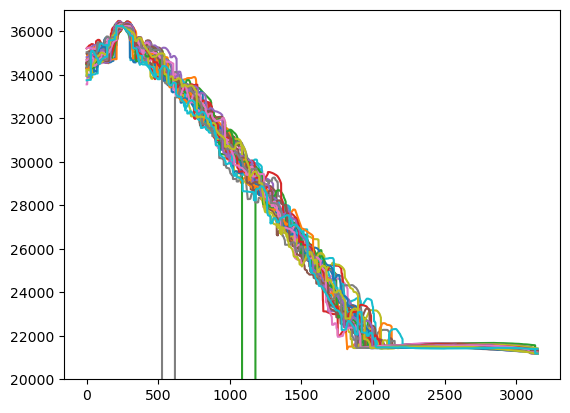

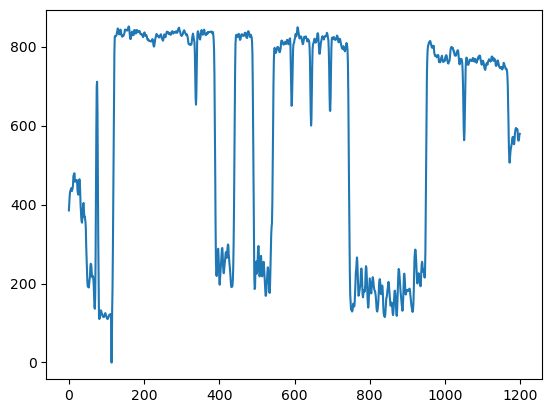

In [76]:
plt.plot(z_data[50:,1:15000:500])
plt.ylim(20000,37000)
plt.show()
plt.plot(lumi_data[2000:,1])
plt.show()

**Kalibrierung der Laserschiefstellung, Leerfahrt importieren**


(20000.0, 37000.0)

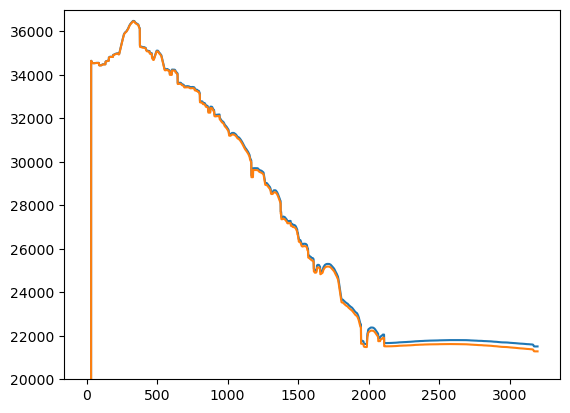

In [77]:
calib_z = np.load(r"C:\Users\lspillec\Nextcloud\Geotechnik-Freigaben\Dienstleistung\Versuche_FuE\F_05_Schüttkegel_Anton\Kalibrierung_leerfahrt\z_20250825_140258.npy")

# hier werden ganz ganz ganz viele Werte am einen Anfang des lasers und am anderen Ende des lasers gesammelt und dann ein Vektor durchgelegt und die echten Messdaten dann mit diesem calibriervektor subtrahiert

oben = np.median(calib_z[:10,1:13000])
unten = np.median(calib_z[:-10,1:13000])
diff = oben-unten 
calibrate = np.linspace(0, -diff, 3200)

z_data_cal = z_data - calibrate[:, None]

plt.plot(z_data_cal[:,5])
plt.plot(z_data[:,5])
plt.ylim(20000,37000)

**Hier werden Ausreißer aufgeräumt, also alle Lücken, die beim Laser einen Wert von ca. 0 oderso ergeben, werden gefüllt.**

In [ ]:
z_clean = interpolate_outliers_linear_radial(
    z_data_cal,
    peak_index=10,          # ab hier ist der Kegel (nein ist er nicht, erst ab ca. 300, aber bissl überlappung ist nicht verkehrt)
    switch_index=2500,      # oberhalb davon ist Luminanz, die ist mir wurscht
    threshold=20000,        # alles darunter sind Ausreiser
    max_gap=200,              # maximale Lückenlänge, die gefüllt wird (hier nochmal genau schauen, vorallem im Randbereich, also an der Spitze des Kegels)
    fill_edge="nearest",    # hier vielleicht verbessern, wenn der Randwert schon "Ausreißer" ist, dann ist das hier dumm. Vielleicht median aus den nächsten 10 Werten oders bilden?
    inplace=False
)


Die beiden Skalierfaktoren:

"scale_height=0.004007365634710554
scale_length=0.050200803212851405"

erstmal so hinnehmen. Sind mit viel willenskraft und schielendem dreiviertel silberblick ermittelt, also sollten so passen.

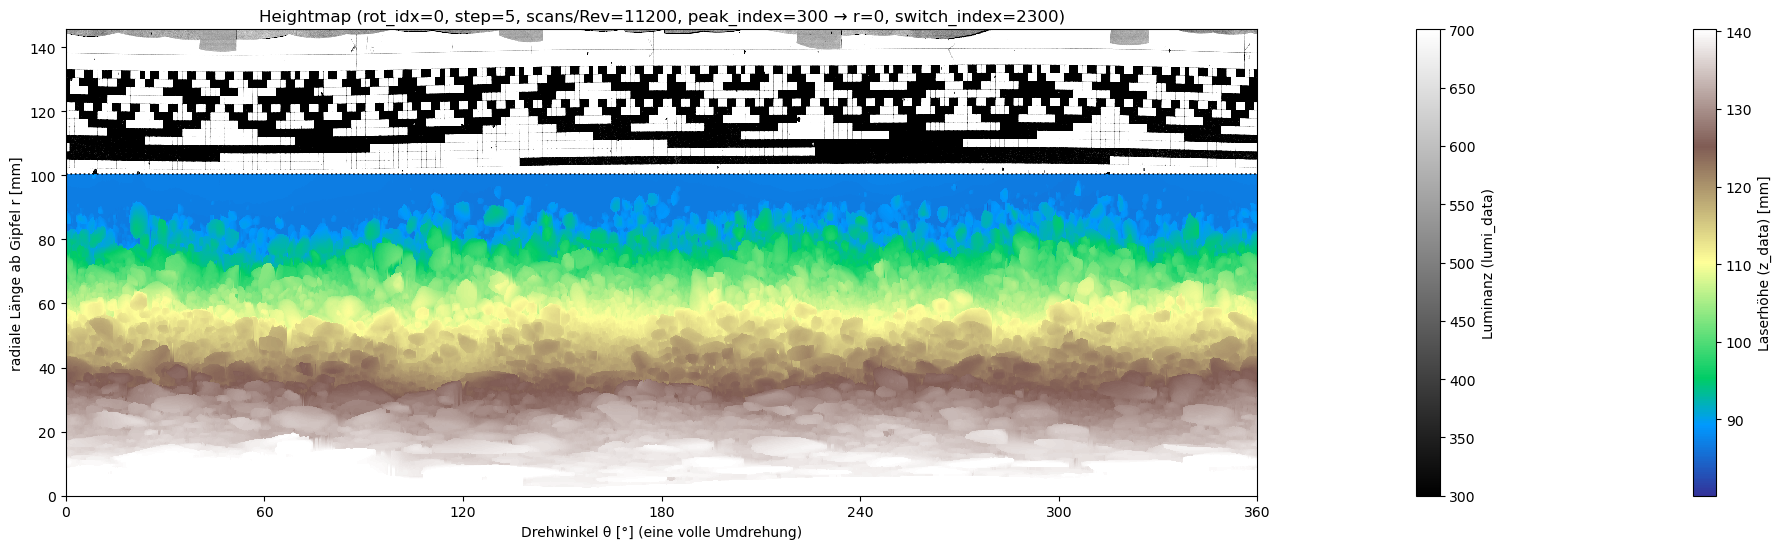

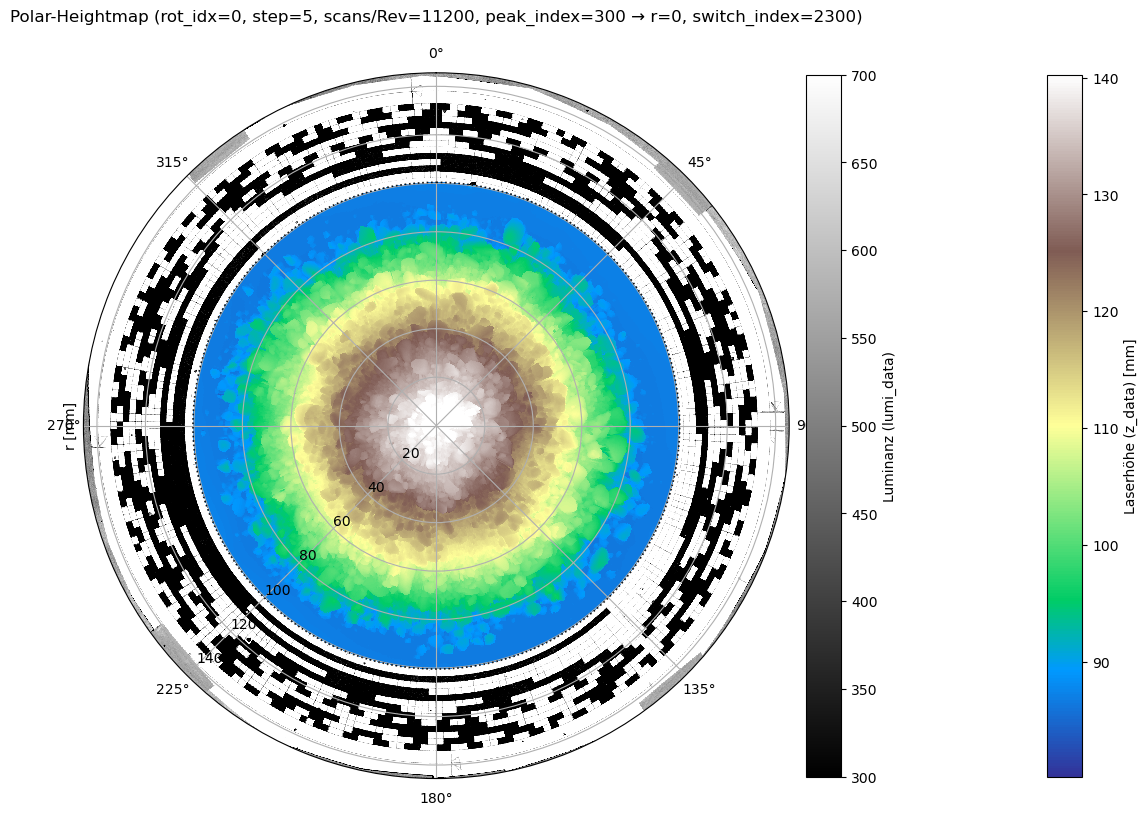

In [79]:
plot_heightmap_from_scans_dualscale(
    z_clean, lumi_data,
    peak_index=300, scans_per_rev=11200, step=5, rotation_idx=0,
    switch_index=2300, y_window_out=(0, 3000),
    scale_height=0.004007365634710554, height_unit="mm",   
    scale_length=0.050200803212851405,  length_unit="mm",   
    # Farbskalen:
    z_vmin=20000, z_vmax=35000,  # werden * scale_height skaliert
    lumi_vmin=300,  lumi_vmax=700, cmap="terrain"
)

plot_polar_heightmap_from_scans_dualscale(
    z_clean, lumi_data,
    peak_index=300, scans_per_rev=11200, step=5, rotation_idx=0,
    switch_index=2300, r_window=(0, 3000),
    scale_height=0.004007365634710554, height_unit="mm",
    scale_length=0.050200803212851405,  length_unit="mm",
    z_vmin=20000, z_vmax=35000, # werden * scale_height skaliert
    lumi_vmin=300,  lumi_vmax=700, cmap="terrain"
)

Spalte 5 – Winkel [°]: -35.17800357632041 Steigung: -0.704847605050647 R²: 0.9887648466295823


<Figure size 640x480 with 0 Axes>

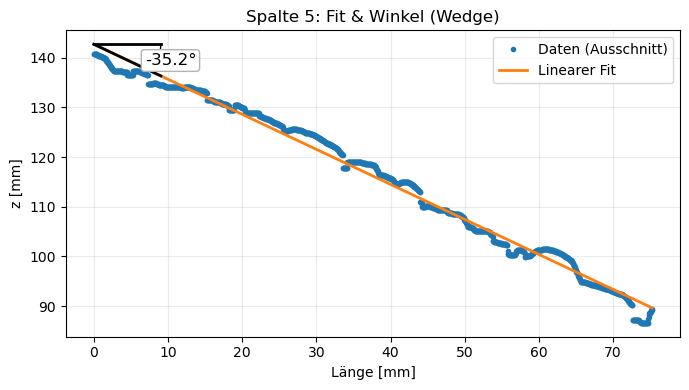

Median-Winkel über alle Spalten [°]: -34.91578098695777


In [80]:
from matplotlib.patches import Arc

scale_height = 0.004007365634710554
scale_length = 0.050200803212851405

res_spalte5 = regression_winkel(z_data_cal[:, 5], start=500, stop=2000)
print("Spalte 5 – Winkel [°]:", res_spalte5["angle_deg"], "Steigung:", res_spalte5["m"], "R²:", res_spalte5["r2"])

plt.figure()
plot_regression_winkel_wedge(z_data_cal[:, 5], start=500, stop=2000, dx=1.0, title="Spalte 5: Fit & Winkel (Wedge)")
plt.show()


res_all = regression_winkel_alle_spalten(z_data_cal, start=500, stop=2000)
print("Median-Winkel über alle Spalten [°]:", res_all["median_winkel_grad"])


In [81]:
res = compute_hill_volume_mm3(
    z_data_cal,
    peak_index=300,
    scans_per_rev=11200,
    rotation_idx=0,
    step=1,                     # für Genauigkeit lieber 1 (kannst erhöhen für Speed)
    switch_index=2300,          # darüber ist lumi → wird ignoriert
    scale_height=0.004007365634710554,         # z-Einheit → mm
    scale_length=0.050200803212851405,          # Pixel → mm (radial)
    z_threshold_min=20000,      # Ausreißer (< 20k) raus (deprecated, da schon cleaning siehe oben passiert)
    z_baseline=22000,           # Referenzniveau (z.B. “Tischplatte”) abziehen
    clip_negative=True
)
print(f"Volumen: {res['volume_cm3']:.3f} cm³")

Volumen: 486.494 cm³
